## <font color='green'> Simulations on the standard error of $\hat{\beta}_{OLS}$ under homoskedastic, heteroskedastic and clustered errors \& four estimators for the standard error

In [1]:
import numpy as np 
import pandas as pd
import math

## <font color='green'> Simulation setup 
* Model: a simple linear regression with group structure - $y_{ig} = x_{ig}\beta_0 + u_{ig}$ for $i=1,...,n$, $g=1,...,G$ 
    - g = group index (the groups are of equal size); i = individual index within groups
    - n = the number of individuals in each group; G = the number of groups
* Four data generating processes for the regression errors ($u_{ig}$)
    - dgp1 = homoskedastic + normal errors (i.e., the errors are independently generated from a normal distribution with a constant variance)
    - dgp2 = heteroskedastic + normal errors (i.e., the errors are independently generated from a normal distribution with varying variance)
    - dgp3 = clustered + normal errors (i.e., the errors are generated from a normal distribution with some covariance between errors within groups)
    - dgp4 = homoskedastic + log-normal errors (i.e., the errors are independently generated from a log-normal distribution with varying variance)
* Four estimators for the standard error of $\hat{\beta}_{OLS}$
    - se1 = $\hat{\sigma}^2 (X^{'}X)^{-1}$
    - se2 = $(X^{'}X)^{-1} \left[ \sum_{i=1}^n x_ix_i^{'} \sigma_i^2 \right] (X^{'}X)^{-1}$ (White)
    - se3 = $(X^{'}X)^{-1} \left[ \sum_{g=1}^G X_{g}^{'} \Sigma_{g}X_{g} \right] (X^{'}X)^{-1} $ (Arellano)
    - se4 = Bootstrap se (which uses individual observation-level resampling, so it is not robust to clustered errors)

### <font color='green'> 1) Data generation

In [2]:
# setting simulation parameters
dgp, n, G, beta0 = 1, 100, 100, 1

In [3]:
# generate a covariate (x) from the standard normal distribution
xmu, xsigma2 = 0, 0.1 # mean and standard deviation
X = np.random.normal(xmu, xsigma2, (n*G,1))
print(X)

[[-0.00252333]
 [-0.02822973]
 [-0.14752546]
 ...
 [-0.00248461]
 [-0.0348068 ]
 [ 0.15743863]]


In [4]:
# generate regression errors
if dgp == 1:
    u = np.random.normal(0, 2, (n*G,1))
    
elif dgp == 2:
    u = np.zeros((n*G,1))
    for i in range(0,n*G):
        sigma2 = abs(X[i,0])
        u[i,0] = np.random.normal(0, sigma2)
        
elif dgp == 3:
    u = np.empty((0,1))
    X = np.empty((0,1))
    for g in range(0,G):
        x0 = np.random.normal(xmu, xsigma2, (n,1)) + np.random.normal(xmu, xsigma2)
        X = np.concatenate((X, np.reshape(x0,(n,1))), axis=0)
        u0 = np.random.normal(0, 1, (n,1)) + np.random.normal(0,1)
        u = np.concatenate((u, np.reshape(u0,(n,1))), axis=0)

else:
     u = (np.exp(np.random.normal(0, 1, (n*G,1)))-np.exp(0.5))/np.sqrt(np.exp(2)-np.exp(1))*np.sqrt((X > 0)*3+(X < 0)*1)

In [5]:
# generate y
Y = X*beta0 + u
print(Y)

[[ 2.00061646]
 [ 0.79433164]
 [ 0.02666713]
 ...
 [-0.97554298]
 [-1.28800836]
 [ 0.97574006]]


### <font color='green'> 2) Calculating the OLS estimate of $\beta_0$ and four different standard error estimates

In [6]:
# OLS estimate
beta_ols = (X.T@Y)/(X.T@X)
print(beta_ols)

[[0.94785037]]


In [7]:
# Four standard error estimates
SES = np.zeros((1,4))

# se1
resid = Y-X*beta_ols
sigma2e = (resid.T@resid)/(X.shape[0]-X.shape[1])
SES[0,0] = np.sqrt(sigma2e/(X.T@X))

C:\Users\gmoor\AppData\Local\Temp\ipykernel_28468\2125788348.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SES[0,0] = np.sqrt(sigma2e/(X.T@X))


In [8]:
# se2
SES[0,1] = np.sqrt(((resid*resid).T@(X*X))/((X.T@X)**2))

C:\Users\gmoor\AppData\Local\Temp\ipykernel_28468\1160179973.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SES[0,1] = np.sqrt(((resid*resid).T@(X*X))/((X.T@X)**2))


In [9]:
# se3
SE30 = 0
for g in range(0,G):
    SE30 += X[g*n:(g+1)*n,0:1].T@(resid[g*n:(g+1)*n,0:1]@resid[g*n:(g+1)*n,0:1].T)@X[g*n:(g+1)*n,0:1]
    
# finite sample adjustment (Hansen, 2007) 
adj = (n*G-1)/(n*G-X.shape[1])*(G)/(G-1)
SES[0,2] = np.sqrt(adj*SE30/((X.T@X)**2))

C:\Users\gmoor\AppData\Local\Temp\ipykernel_28468\1192349785.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SES[0,2] = np.sqrt(adj*SE30/((X.T@X)**2))


In [10]:
# se4
from sklearn.utils import resample
B = 1000
Boot = np.zeros((B,1))
for b in range(0,B):
    Yr, Xr = resample(Y, X)
    Boot[b,0] = (Xr.T@Yr)/(Xr.T@Xr)
    
SE4 = np.std(Boot)

C:\Users\gmoor\AppData\Local\Temp\ipykernel_28468\720010153.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Boot[b,0] = (Xr.T@Yr)/(Xr.T@Xr)


In [11]:
# trimming extreme values
Boot2 = np.sort(Boot, axis=0)
SES[0,3] = np.std(Boot2[int(B*0.001):int(B*0.999),0:1])

In [12]:
print(SES)

[[0.19686728 0.19198258 0.17872769 0.18222477]]


### <font color='green'> 3) Compare the standard errors using 95% confidence intervals

In [13]:
# check if the confidence intervals constructed by the four s.e. methods contain the true parameter value
CI = ((beta_ols - 1.96*SES) < beta0)*((beta_ols + 1.96*SES) > beta0)*1
print(CI)

[[1 1 1 1]]


## <font color='green'> Simulations

In [14]:
# define a function for simulations

def simul(dgp,n,G,B,beta0,itern): # B = # of bootstrap samples in se4; itern = # of simulations 
    CI = np.zeros((itern,4))
    BETA = np.zeros(itern)
    
    for s in range(0,itern):
        xmu, xsigma2 = 0, 0.1
        X = np.random.normal(xmu, xsigma2, (n*G,1))
        
        if dgp == 1:
            u = np.random.normal(0, 2, (n*G,1))
            
        elif dgp == 2:
            u = np.zeros((n*G,1))
            for i in range(0,n*G):
                sigma2 = abs(X[i,0])
                u[i,0] = np.random.normal(0, sigma2)
            
        elif dgp == 3:
            u = np.empty((0,1))
            X = np.empty((0,1))
            for g in range(0,G):
                x0 = np.random.normal(xmu, xsigma2, (n,1)) + np.random.normal(xmu, xsigma2)
                X = np.concatenate((X, np.reshape(x0,(n,1))), axis=0)
                u0 = np.random.normal(0, 1, (n,1)) + np.random.normal(0,1)
                u = np.concatenate((u, np.reshape(u0,(n,1))), axis=0)
        else:
            u = (np.exp(np.random.normal(0, 1, (n*G,1)))-np.exp(0.5))/np.sqrt(np.exp(2)-np.exp(1))
            
        Y = X*beta0 + u
        beta_ols = (X.T@Y)/(X.T@X)
        BETA[s] = beta_ols
        
        SES = np.zeros((1,4))
        resid = Y-X*beta_ols
        sigma2e = (resid.T@resid)/(X.shape[0]-X.shape[1])
        SES[0,0] = np.sqrt(sigma2e/(X.T@X))
        SES[0,1] = np.sqrt(((resid*resid).T@(X*X))/((X.T@X)**2))
        
        SE30 = 0
        for g in range(0,G):
            SE30 += X[g*n:(g+1)*n,0:1].T@(resid[g*n:(g+1)*n,0:1]@resid[g*n:(g+1)*n,0:1].T)@X[g*n:(g+1)*n,0:1]
    
        adj = (n*G-1)/(n*G-X.shape[1])*(G)/(G-1)
        SES[0,2] = np.sqrt(adj*SE30/((X.T@X)**2))
        
        Boot = np.zeros((B,1))
        for b in range(0,B):
            Yr, Xr = resample(Y, X)
            Boot[b,0] = (Xr.T@Yr)/(Xr.T@Xr)
    
        Boot2 = np.sort(Boot, axis=0)
        SES[0,3] = np.std(Boot2[int(B*0.001):int(B*0.999),0:1])
        
        CI[s,:] = ((beta_ols - 1.96*SES) < beta0)*((beta_ols + 1.96*SES) > beta0)*1
    
    CI_rate = np.mean(CI, axis=0)
    
    return CI_rate, BETA

In [15]:
CI_rate, BETA = simul(3,10,50,500,1,1000) #(dgp,n,G,B,beta0,itern)
# CI_rate (Coverage rate) = proportions of iterations that a given s.e. method's CIs includes the true value
# BETA = beta estimates over the iterations

C:\Users\gmoor\AppData\Local\Temp\ipykernel_28468\1518527123.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BETA[s] = beta_ols
C:\Users\gmoor\AppData\Local\Temp\ipykernel_28468\1518527123.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SES[0,0] = np.sqrt(sigma2e/(X.T@X))
C:\Users\gmoor\AppData\Local\Temp\ipykernel_28468\1518527123.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  SES[0,1] = np.sqrt(((resid*resid).T@(X*X))/((X.T@X)**2))
C:\Users\gmoor\

In [16]:
print(CI_rate)

[0.729 0.728 0.929 0.727]


In [17]:
print(np.std(BETA))
print(np.mean(BETA, axis=0))

0.8085508271166821
0.9403269607846043


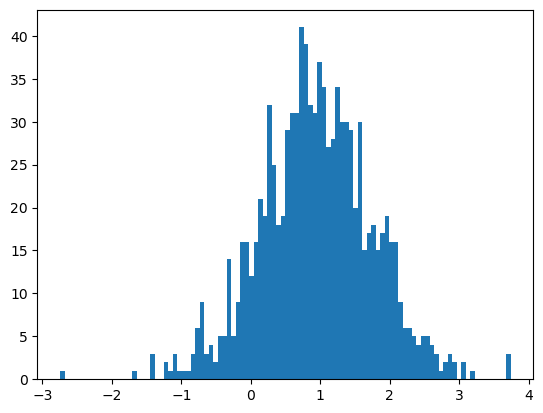

In [18]:
import matplotlib.pyplot as plt
plt.hist(BETA,bins = 100)
plt.show()

### <font color='green'> Question 1: Using the function, run simulations and calculate relevant statistics/graphs to support the following statement
* <font color='red'> "The OLS estimator is unbiased even if the errors are heteroskedastic or clustered or non-normal"
* Throughout the simulations, set n = 10, G = 50, B = 500, itern = 1000

### <font color='green'> Question 2: Interpretation of over- or under-coverage
    (1) For dgp = 2 or 3, run simulations and compute CI_rates (throughout the simulations, set n = 10, G = 50, B = 500, itern = 1000). You will find some s.e. methods exhibit coverage rates significantly lower than the confidence level 0.95. How would you interpret coverage rates being lower or higher than the confidence level?
    
    (2) To answer the question, modify the function so that it stores the standard errors computed from the four s.e. methods over the iterations and return them as a result item. Then, calculate the averages of the standard errors computed from each s.e. method and compare them with the standard deviation of the beta estimates over the iteration. The s.d. of the beta estimates can be regarded as the true standard error.

    
    (3) Using the results, explain why certain s.e. methods resulted in covarge rates significantly lower than 0.95 and relate them to the properties of the four s.e. methods (recall the meaning of standard error!)

# Answers: 

### Question 1:

              Data Type  Mean Beta  Std Beta
0  Homoskedastic Normal   0.970629  0.867894
1       Heteroskedastic   1.000707  0.078645
2             Clustered   0.976122  1.501778
3            Log-Normal   1.015856  0.640964


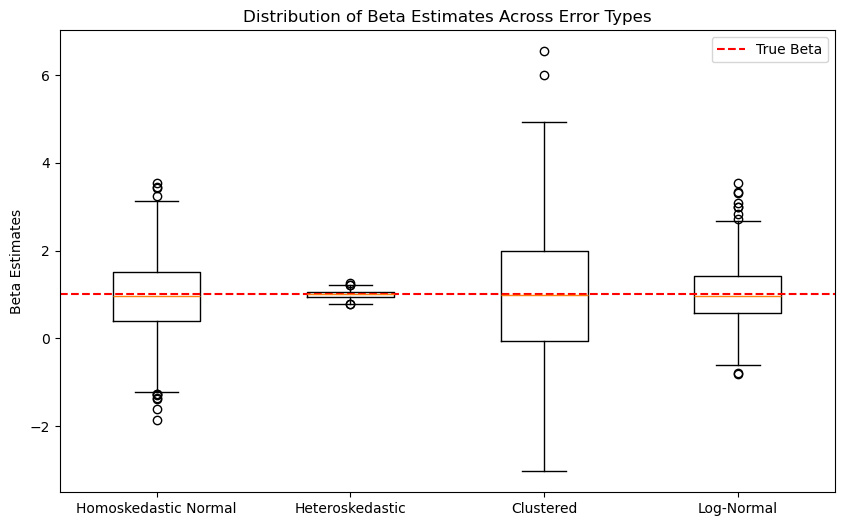

In [25]:
# Question 1: function to run the simulation based on a specified DGP and return standard errors and OLS estimates 
import numpy as np
import matplotlib.pyplot as plt

def simul(dgp, n, G, B, beta0, itern):
    CI = np.zeros((itern, 4))
    BETA = np.zeros(itern)
    
    for s in range(0, itern):
        xmu, xsigma2 = 0, 0.1
        X = np.random.normal(xmu, xsigma2, (n*G, 1))
        
        if dgp == 1:
            u = np.random.normal(0, 2, (n*G, 1))
        elif dgp == 2:
            u = np.random.normal(0, np.abs(X.flatten())).reshape(-1, 1)
        elif dgp == 3:
            X = np.repeat(np.random.normal(xmu, xsigma2, (G, 1)), n, axis=0)
            u = np.repeat(np.random.normal(0, 1, (G, 1)), n, axis=0) + np.random.normal(0, 1, (n*G, 1))
        else:  # dgp == 4
            u = np.exp(np.random.normal(0, 1, (n*G, 1)))
            u = (u - np.exp(0.5)) / np.sqrt(np.exp(2) - np.exp(1))
            u *= np.sqrt(np.where(X > 0, 3, 1))
        
        Y = X * beta0 + u
        beta_ols = (X.T @ Y) / (X.T @ X)
        BETA[s] = beta_ols[0, 0]
        
        # We're not calculating CI here as it's not needed for this question
    
    return BETA

# Run simulations
np.random.seed(42)  # For reproducibility
n, G, B, beta0, itern = 10, 50, 500, 1, 1000

dgp_types = {1: 'Homoskedastic Normal', 2: 'Heteroskedastic', 3: 'Clustered', 4: 'Log-Normal'}
results = {}

for dgp in range(1, 5):
    beta_estimates = simul(dgp, n, G, B, beta0, itern)
    results[dgp_types[dgp]] = {
        'beta_estimates': beta_estimates,
        'mean_beta': np.mean(beta_estimates),
        'std_beta': np.std(beta_estimates)
    }

# Create summary dataframe
summary_df = pd.DataFrame({
    'Data Type': list(results.keys()),
    'Mean Beta': [r['mean_beta'] for r in results.values()],
    'Std Beta': [r['std_beta'] for r in results.values()]
})

print(summary_df)

# Create box plot
plt.figure(figsize=(10, 6))
plt.boxplot([r['beta_estimates'] for r in results.values()], labels=results.keys())
plt.axhline(y=1, color='r', linestyle='--', label='True Beta')
plt.title("Distribution of Beta Estimates Across Error Types")
plt.ylabel("Beta Estimates")
plt.legend()
plt.show()

### Question 2: 

#### (1):
##### <font color='blue'> Answer: I would interpret coverage rates being lower than the confidence level as an indication the confidence intervals are too narrow, the standard errors are likely underestimated. The coverage rates being higher than the confidence level suggests the confidence intervals are too wide and the standard errors are likely overestimated. If the coverage rates are close to the nominal confidence level this indicates the method is well-calibrated and the standard errors are accurately estimated. 

#### (2):

In [28]:
def simul(dgp, n, G, B, beta0, itern):
    CI = np.zeros((itern, 4))
    BETA = np.zeros(itern)
    SE = {f'se{i}': np.zeros(itern) for i in range(1, 5)}
    
    for s in range(0, itern):
        xmu, xsigma2 = 0, 0.1
        X = np.random.normal(xmu, xsigma2, (n*G, 1))
        
        if dgp == 1:
            u = np.random.normal(0, 2, (n*G, 1))
        elif dgp == 2:
            u = np.random.normal(0, np.abs(X.flatten())).reshape(-1, 1)
        elif dgp == 3:
            X = np.repeat(np.random.normal(xmu, xsigma2, (G, 1)), n, axis=0)
            u = np.repeat(np.random.normal(0, 1, (G, 1)), n, axis=0) + np.random.normal(0, 1, (n*G, 1))
        else:  # dgp == 4
            u = np.exp(np.random.normal(0, 1, (n*G, 1)))
            u = (u - np.exp(0.5)) / np.sqrt(np.exp(2) - np.exp(1))
            u *= np.sqrt(np.where(X > 0, 3, 1))
        
        Y = X * beta0 + u
        beta_ols = (X.T @ Y) / (X.T @ X)
        BETA[s] = beta_ols[0, 0]
        
        # Calculate residuals
        resid = Y - X * beta_ols
        
        # Standard error calculations
        SE['se1'][s] = np.sqrt(np.sum(resid**2) / (n*G - 1) / np.sum(X**2))
        SE['se2'][s] = np.sqrt(np.sum((resid**2 * X**2)) / np.sum(X**2)**2)
        
        se3 = 0
        for g in range(G):
            Xg = X[g*n:(g+1)*n]
            residg = resid[g*n:(g+1)*n]
            se3 += (Xg.T @ residg) ** 2
        SE['se3'][s] = np.sqrt(se3[0,0] / np.sum(X**2)**2)
        
        # Bootstrap standard error
        bootstrap_betas = []
        for _ in range(B):
            boot_idx = np.random.choice(n*G, n*G, replace=True)
            X_boot, Y_boot = X[boot_idx], Y[boot_idx]
            beta_boot = (X_boot.T @ Y_boot) / (X_boot.T @ X_boot)
            bootstrap_betas.append(beta_boot[0,0])
        SE['se4'][s] = np.std(bootstrap_betas)
    
    return BETA, SE

# Run simulations
np.random.seed(42)
n, G, B, beta0, itern = 10, 50, 500, 1, 1000

results = {}
for dgp in [2, 3]:
    BETA, SE = simul(dgp, n, G, B, beta0, itern)
    true_se = np.std(BETA)
    avg_se = {method: np.mean(se) for method, se in SE.items()}
    
    results[f'dgp_{dgp}'] = {
        'true_se': true_se,
        'avg_se': avg_se
    }

# Print results
for dgp, res in results.items():
    print(f"\nResults for {dgp}:")
    print(f"True SE: {res['true_se']:.6f}")
    for method, se in res['avg_se'].items():
        print(f"{method}: {se:.6f}")


Results for dgp_2:
True SE: 0.079698
se1: 0.044651
se2: 0.076419
se3: 0.075609
se4: 0.076136

Results for dgp_3:
True SE: 1.565203
se1: 0.637329
se2: 0.629683
se3: 1.445012
se4: 0.629962


#### (2):
##### <font color='blue'> Answer: The results show that the standard error methods not accounting for the true error structure lead to underestimation of standard errors and consequently lower coverage rates. For DPG_2, only the homoskedasticity-assuming method (se1) performs poorly, while the others are accurate. For DPG_3, only the cluster-robust method (se3) performs well because it correctly accounts for within-cluster correlation. These results overall show the importance of choosing standard eror estimation methods that match the underlying data, ensuring accurate statistical inference.